In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.manifold import MDS
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import csr_matrix
import ast
import xgboost as xgb

/home/ho/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Data clean

In [138]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [139]:
path = '/home/ho/Shared/Linux/kaggle/data/wine/'

In [140]:
df = pd.read_csv(f'{path}winemag-data-130k-v2.csv',
                 low_memory=False, index_col=0)
df = df.drop_duplicates()

In [ ]:
df.taster_name.value_counts().plot.barh()

In [ ]:
df.nunique()

In [ ]:
df[df.variety.isnull()]

In [ ]:
df = df.drop([86909])

In [3]:
# drop the row of variety<=10
def drop(name_columns, drop_condition, data_old, data_new):
    '''drop form name_columns by drop_condition'''
    data_new = data_old
    for i in drop_condition:
        data_old = data_new
        x = data_old[name_columns] != i
        data_new = data_old[x]
    return data_new


In [ ]:


drop_con_variety = df.variety.value_counts(
)[df.variety.value_counts() <= 10].index

data = df
data_variety = drop('variety', drop_con_variety, df, data)


drop_con_description = data.description.value_counts(
)[data.description.value_counts() >= 2].index

data = data_variety
data = drop('description', drop_con_description, data_variety, data)

In [ ]:
data = data.reset_index(drop=True)
data.nunique()

In [ ]:
data.variety.value_counts()[data.variety.value_counts() > 3000].index

In [ ]:
data['description'] = data.apply(
    lambda x: re.sub(r'[\\—\d+./-]', ' ', x['description']), axis=1)

In [ ]:
def tokenize(text):
    '''divides a string into substrings and remove stop words'''
    text = text['description'].lower()
    text = nltk.word_tokenize(text)
    stopwords = set(nltk.corpus.stopwords.words('english')
                    ) | set([',', '\'s', '%', '.', 'n\'t', '()', ';', '&', ':', '.°'])
    content = [x for x in text if x not in stopwords]
    return content

In [ ]:
data['description'] = data.apply(tokenize, axis=1)

In [78]:
def collect_words(data):
    '''collect all words'''
    x = data.loc[0, 'description'].copy()
    for i in range(1, len(data)):
        for j in range(len(data['description'][i])):
            x.append(data.loc[i, 'description'][j])
    return x

In [ ]:



def frequency_clean(words):
    '''clean the words of frequency == 1'''
    x = pd.DataFrame(words)
    drop_x = x[0].value_counts()[x[0].value_counts() == 1].index
    word_new = set(words) - set(drop_x)
    return list(word_new)


words = collect_words(data)
words = frequency_clean(words)

In [ ]:
def content_fraction(text, words):
    '''clean the words of frequency == 1 from data'''
    content = [x for x in text if x in words]
    return content

In [ ]:
data['description'] = data['description'].apply(
    content_fraction, args=(words,))

In [ ]:
%mkdir tmp

In [ ]:
words = pd.DataFrame(words)

words.T.to_csv('tmp/words.csv')

data['labels_variety'] = data.variety.factorize()[0]
data.to_csv('tmp/data.csv')

# Read data

## Linux

In [6]:
df = pd.read_csv('tmp/data.csv', low_memory=False, index_col=0,
                 converters={'description': ast.literal_eval})
words = pd.read_csv('tmp/words.csv', low_memory=False,
                    index_col=0, converters={'description': ast.literal_eval})
words = list(words.loc[0, :])

## windows

In [13]:
df = pd.read_csv('C:/Users/user/Desktop/ho/data.csv', low_memory=False, index_col=0,
                 converters={'description': ast.literal_eval})
words = pd.read_csv('C:/Users/user/Desktop/ho/words.csv', low_memory=False,
                    index_col=0, converters={'description': ast.literal_eval})
words = list(words.loc[0, :])

## Useless

In [ ]:
test = np.memmap('test.mymemmap', dtype='float32',
                 mode='w+', shape=(100000, 20000))

In [ ]:
test = pd.DataFrame(test)

In [ ]:
test.iloc[0, 0]

In [ ]:
def union(data):
    '''union the word of description'''
    x = set([])
    for i in range(len(data)):
        x = set(data['description'][i]) | x
    columns = list(x)
    matrix = np.memmap('test.mymemmap', dtype='float32',
                       mode='w+', shape=((len(data), len(columns))))
    matrix = pd.DataFrame(data=matrix, columns=columns)
    return matrix


def create(data, matrix):
    '''create matrix of 0,1'''
    for i in range(len(data)):
        for j in range(len(data['description'][i])):
            columns = data['description'][i][j]
            matrix.loc[i, columns] = 1
    return matrix


matrix = union(data)


# test = pd.DataFrame(np.zeros((5,3)), columns=['description', '0', '1'])

# range(len(test['description'][0]))

# matrix = pd.DataFrame(np.zeros((5,4)), columns=['a', 'b', 'c', 'd'])

# for i in range(len(test)):
#     for j in range(len(test['description'][i])):
#         columns = test['description'][i][j]
#         matrix.loc[i, columns] = 1

# for j in range(len(test['description'][0])):
#     print(j)

# test = test.drop(['descripion'], axis=1)

# test
'''MDS'''
# embedding = MDS(n_components=3, n_jobs=7)
# X_transformed = embedding.fit_transform(matrix)
# X_transformed.shape

# MDS

In [76]:
def data_matrix_mean(data, words):
    matrix = pd.DataFrame(np.zeros((data.variety.nunique(), len(words))),
                          index=data.variety.factorize()[1], columns=words)
    for i in range(data.variety.nunique()):
        x = data[data['labels_variety'] == i]
        x = x.reset_index(drop=True)
        x = collect_words(x)  # collect_words() is a function
        x = pd.DataFrame(nltk.FreqDist(x), index=[0])
        col = list(set(x) & set(words))
        for j in range(len(col)):
            frequency = x.loc[0, col[j]] / len(col)
            matrix.loc[matrix.index[[i]], col[j]] = frequency
    return matrix

In [90]:
df['labels_variety'] = df.variety.factorize()[0]

data_matrix = data_matrix_mean(df, words)

In [91]:
corr = data_matrix.T.corr()

In [92]:
distance = corr.applymap(lambda x: 1 - x**2)

In [93]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
mds_2d = embedding.fit_transform(distance)

In [94]:
embedding = MDS(n_components=3, dissimilarity='precomputed')
mds_3d = embedding.fit_transform(distance)

In [95]:
%matplotlib notebook
%matplotlib notebook

In [96]:
mds_2d = pd.DataFrame(mds_2d, index=data_matrix.index, columns=['x', 'y'])

In [106]:
most_variety = list(df.variety.value_counts()[
                    df.variety.value_counts() > 4300].index)

In [107]:
len(most_variety)

7

<IPython.core.display.Javascript object>


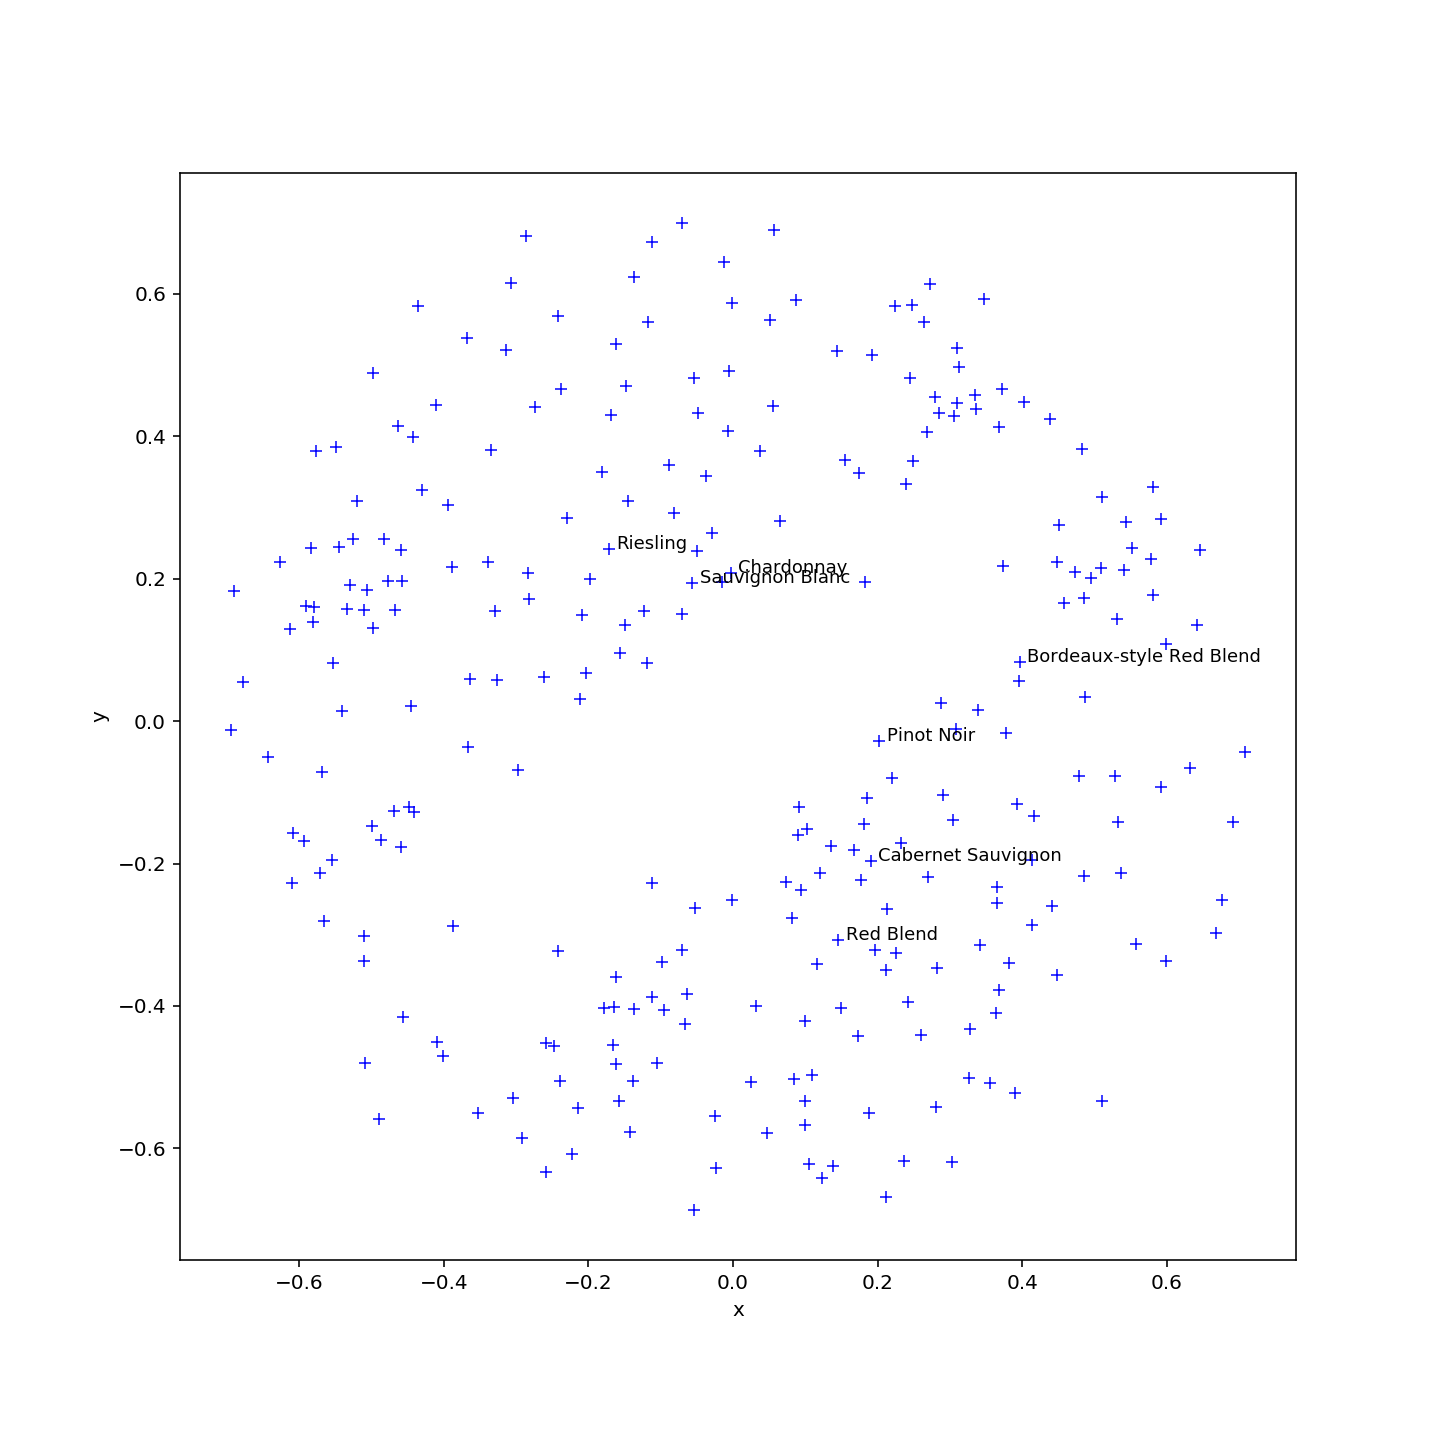

In [108]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
axes = sns.scatterplot(data=mds_2d, x="x", y="y", marker="+", color="blue")
for name in most_variety:
    axes.text(mds_2d.loc[name, 'x']+0.01,
              mds_2d.loc[name, 'y'], s=name, fontsize=9)

<IPython.core.display.Javascript object>


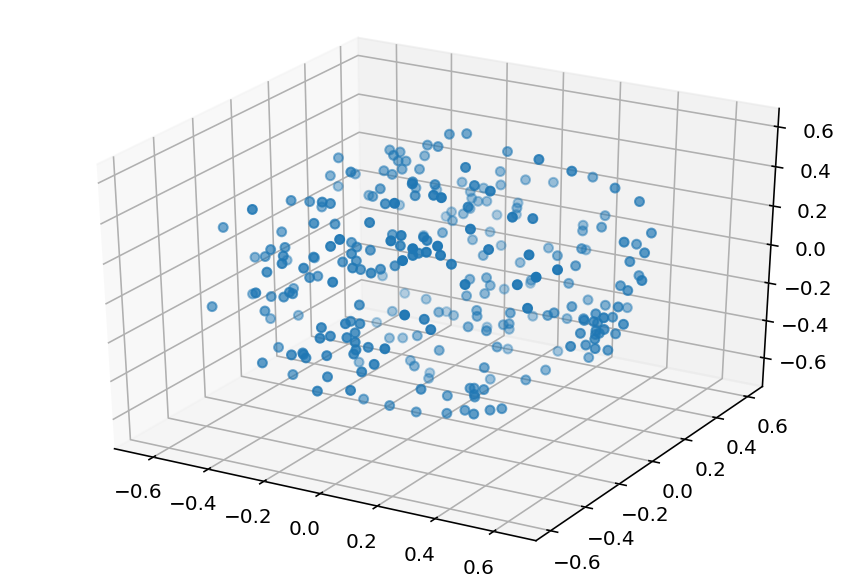

In [100]:
mds_3d = pd.DataFrame(mds_3d, index=data_matrix.index, columns=['x', 'y', 'z'])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(mds_3d['x'], mds_3d['y'], mds_3d['z'])

# XGboost

In [4]:
def spilt_vals(data, proportion):
    test = pd.DataFrame()
    for i in data.variety.factorize()[1]:
        x = data['variety'] == i
        valid = data[x]
        valid = valid.sample(frac=proportion)
        test = test.append(valid)
    data = data.drop(test.index)
    data = data.reset_index(drop=True)
    test = test.reset_index(drop=True)
    return data, test

In [5]:
def data_matrix(data, words):
    '''create data_matrix of 0,1'''
    matrix = csr_matrix((len(data), len(words)), dtype=np.int8).toarray()
    for i in range(len(data)):
        for j in range(len(data['description'][i])):
            columns = data['description'][i][j]
#             if columns in words:
            columns = words.index(columns)
            matrix[i, columns] = 1
    return matrix

## binary

In [7]:
drop_con_variety = df.variety.value_counts(
)[df.variety.value_counts() <= 10000].index

data = df
data_variety = drop('variety', drop_con_variety, df, data)

In [8]:
df = data_variety.copy()

In [19]:
from sklearn.metrics import accuracy_score

print("Training Error: %.2f" % (1 - accuracy_score(y_train, train_pred)))
print("Testing Error: %.2f" % (1 - accuracy_score(y_test, test_pred)))


Training Error: 0.03
Testing Error: 0.03


## six

In [162]:
drop_con_variety = df.variety.value_counts()[6:].index

data = df
data_variety = drop('variety', drop_con_variety, df, data)
df = data_variety.copy()

In [161]:
df.variety.value_counts()

Pinot Noir                        12276
Chardonnay                        10865
Cabernet Sauvignon                 8833
Red Blend                          8237
Bordeaux-style Red Blend           6467
Riesling                           4773
Sauvignon Blanc                    4574
Syrah                              3824
Rosé                               3220
Merlot                             2895
Nebbiolo                           2597
Zinfandel                          2530
Sangiovese                         2458
Malbec                             2445
Portuguese Red                     2282
White Blend                        2178
Sparkling Blend                    1971
Tempranillo                        1671
Rhône-style Red Blend              1343
Pinot Gris                         1324
Champagne Blend                    1308
Cabernet Franc                     1242
Grüner Veltliner                   1199
Portuguese White                   1057
Bordeaux-style White Blend          993


In [84]:
from sklearn.metrics import accuracy_score

print("Training Error: %.2f" % (1 - accuracy_score(y_train, train_pred)))
print("Testing Error: %.2f" % (1 - accuracy_score(y_test, test_pred)))

Training Error: 0.20
Testing Error: 0.21


In [27]:
confusion

,Pinot Noir,Chardonnay,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Riesling
Pinot Noir,3107,168,132,57,214,5
Chardonnay,10,3193,4,6,5,42
Cabernet Sauvignon,385,101,1865,176,123,0
Red Blend,268,65,253,1715,170,0
Bordeaux-style Red Blend,141,105,162,127,1402,3
Riesling,13,445,2,0,1,971


## test

In [16]:
train, test = spilt_vals(df, 0.3)

In [10]:
x_train = data_matrix(train, words)
x_test = data_matrix(test, words)


In [11]:
y_train = np.array(train['labels_variety'])
y_test = np.array(test['labels_variety'])

In [12]:
dtrain = xgb.DMatrix(x_train, label=y_train)

In [18]:
xgb_model = xgb.XGBClassifier(n_job=-1, nthread=8).fit(x_train, y_train)

In [23]:
test_pred = xgb_model.predict(x_test)

In [24]:
train_pred = xgb_model.predict(x_train)

In [29]:
def error(y_hat, y_ture):
    count = 0
    for i in range(len(y_ture)):
        if y_hat[i] != y_ture[i]:
            count += 1
    return count / len(y_hat)

In [30]:
error(y_train, train_pred)

0.20335971123143134

In [105]:
np.save('y_test', y_test)

In [108]:
np.save('test_pred', test_pred)

## confusion_matrix

In [22]:
def choose(df, variety):
    labels_variety = []
    for i in variety:
        data = df[df.variety == i]
        data = data.reset_index()
        labels_variety.append(data.labels_variety[0])
    return labels_variety

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
labels = choose(df, df.variety.value_counts().index)

In [25]:
confusion = confusion_matrix(y_test, test_pred, labels=labels)

In [26]:
confusion = pd.DataFrame(confusion, index=df.variety.value_counts().index, columns=df.variety.value_counts().index)

row true

In [27]:
confusion

,Pinot Noir,Chardonnay,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Riesling
Pinot Noir,3107,168,132,57,214,5
Chardonnay,10,3193,4,6,5,42
Cabernet Sauvignon,385,101,1865,176,123,0
Red Blend,268,65,253,1715,170,0
Bordeaux-style Red Blend,141,105,162,127,1402,3
Riesling,13,445,2,0,1,971


In [127]:
len(df)

118576

In [157]:
from sys import getsizeof

In [160]:
getsizeof(df)

119045835